# THIRD HOME ASSIGNEMENT
Lucía García Salido (62443). Pablo Diego Acosta (62464)

### IMPORTS

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, PowerTransformer
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.decomposition import PCA, KernelPCA

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import matthews_corrcoef, mean_squared_error, max_error, mean_absolute_error, explained_variance_score

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import pickle

### Lecture


In [45]:
data_path = 'data/drd2_data.pickle'
X_main, X_ivs, y_main, col_names = pickle.load(open(data_path, "rb"))

In [46]:
col_names_D = [i for i,col in enumerate(col_names) if 'D' in col]
col_names_F = [i for i,col in enumerate(col_names) if 'F' in col]
len(col_names_D)+len(col_names_F)

2132

### Dimension Reductor Selection

Auxiliar Function for naive evaluation in dimensionality reductor research

In [14]:

def naif_model_testingR(X_train, X_test, y_train, y_test):
    rfr= RandomForestRegressor(n_estimators=100)
    rfr.fit(X_train, y_train)

    # dtr= DecisionTreeRegressor(max_depth=20)
    # dtr.fit(X_train, y_train)

    # lmr=LinearRegression()
    # lmr.fit(X_train, y_train)
    
    xgb=XGBRegressor()
    xgb.fit(X_train,y_train)
    
    knn=KNeighborsRegressor(n_neighbors=5, weights='distance')
    knn.fit(X_train,y_train)
    
    svr=SVR(C=1.0, epsilon=0.05)
    svr.fit(X_train,y_train)
    
    # ada=AdaBoostRegressor(estimator=LinearRegression(), n_estimators=50)
    # ada.fit(X_train,y_train)

    rf_preds=rfr.predict(X_test)
    # dt_preds=dtr.predict(X_test)
    # lr_preds=lmr.predict(X_test)
    xgb_preds=xgb.predict(X_test)
    knn_preds=knn.predict(X_test)
    svr_preds=svr.predict(X_test)
    # ada_preds=ada.predict(X_test)

    print("RVE RFs: %7.4f;  MAE: %7.4f" % (explained_variance_score(y_test, rf_preds), mean_absolute_error(y_test,rf_preds)))
    # print("RVE DTs: %7.4f;  MAE: %7.4f" % (explained_variance_score(y_test, dt_preds), mean_absolute_error(y_test,dt_preds)))
    # print("RVE LRs: %7.4f;  MAE: %7.4f" % (explained_variance_score(y_test, lr_preds), mean_absolute_error(y_test,lr_preds)))
    print("RVE XGBs: %7.4f;  MAE: %7.4f" % (explained_variance_score(y_test, xgb_preds), mean_absolute_error(y_test,xgb_preds)))
    print("RVE KNNs: %7.4f;  MAE: %7.4f" % (explained_variance_score(y_test, knn_preds), mean_absolute_error(y_test,knn_preds)))
    print("RVE SVRs: %7.4f;  MAE: %7.4f" % (explained_variance_score(y_test, svr_preds), mean_absolute_error(y_test,svr_preds)))
    # print("RVE ADAs: %7.4f;  MAE: %7.4f" % (explained_variance_score(y_test, ada_preds), mean_absolute_error(y_test,ada_preds)))

def dim_reductor_naif_explore(reductor, X_train, X_test, y_train, y_test, needs_y=False):
    if needs_y:
        reductor.fit(X_train,y_train)
    else:
        reductor.fit(X_train)
    nX_train = reductor.transform(X_train)
    nX_test = reductor.transform(X_test)
    naif_model_testingR(nX_train, nX_test, y_train, y_test)
    return nX_train, nX_test, reductor


In [7]:
# In order to compare differents techniques we split the main set into train and test
X_train,X_test,y_train,y_test = train_test_split(X_main,y_main,test_size=0.3, random_state=42)

### Scaler

In [48]:
scaler = StandardScaler()
Xt_train = scaler.fit_transform(X_train)
Xt_test = scaler.transform(X_test)

### SelectFromModel

In [42]:
from sklearn.feature_selection import SelectFromModel
rf = RandomForestRegressor()
sel = SelectFromModel(estimator=rf, threshold="mean")
sel.fit(Xt_train,y_train)

SelectFromModel(estimator=RandomForestRegressor(), threshold='mean')

In [43]:
nX_train = sel.transform(Xt_train)
nX_test = sel.transform(Xt_test)

In [44]:
nX_train.shape

(5135, 351)

In [45]:
naif_model_testingR(nX_train, nX_test, y_train, y_test)

RVE RFs:  0.6239;  MAE:  0.1276
RVE XGBs:  0.6080;  MAE:  0.1298
RVE KNNs:  0.6064;  MAE:  0.1256
RVE SVRs:  0.6497;  MAE:  0.1211


In [21]:
N,M=Xt_train.shape
features=sel.get_support()
Features_selected =np.arange(M)[features]
print("The number of features selected are: ", len(Features_selected))

The number of features selected are:  338


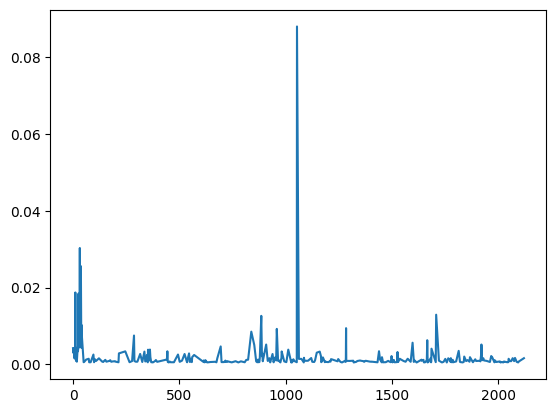

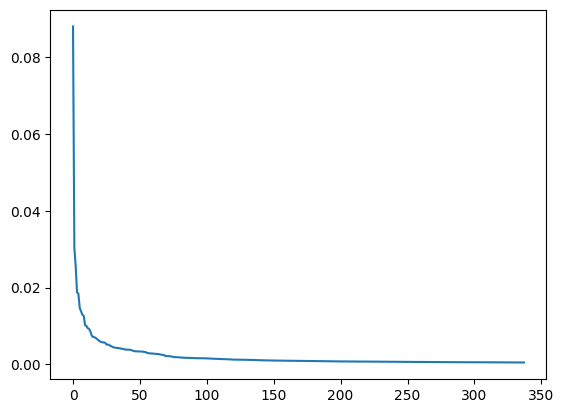

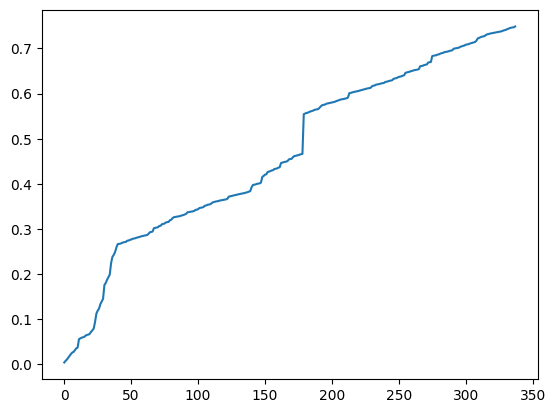

In [27]:
feature_importances = sel.estimator_.feature_importances_
feature_importances_selected = feature_importances[Features_selected]
plt.plot(Features_selected, feature_importances_selected)
plt.show()

importances_sorted = np.sort(feature_importances_selected)[::-1]
plt.plot(np.arange(len(Features_selected)), importances_sorted)
plt.show()

importances_cumsum = np.cumsum(feature_importances_selected)
plt.plot(np.arange(len(Features_selected)), importances_cumsum)
plt.show()


In [37]:
threshold = -np.inf
max_features = 100
rf = RandomForestRegressor()
sel = SelectFromModel(estimator=rf, threshold=threshold, max_features=max_features)
sel.fit(Xt_train,y_train)

SelectFromModel(estimator=RandomForestRegressor(), max_features=100,
                threshold=-inf)

In [38]:
nX_train = sel.transform(Xt_train)
nX_test = sel.transform(Xt_test)

In [39]:
naif_model_testingR(nX_train, nX_test, y_train, y_test)

RVE RFs:  0.5753;  MAE:  0.1363
RVE XGBs:  0.5434;  MAE:  0.1416
RVE KNNs:  0.5311;  MAE:  0.1388
RVE SVRs:  0.5608;  MAE:  0.1363


In [40]:
N,M=Xt_train.shape
features=sel.get_support()
Features_selected =np.arange(M)[features]
print("The number of features selected are: ", len(Features_selected))

The number of features selected are:  100


### KernelPCA Research

In [9]:
n_components = 100
kpca = KernelPCA(n_components=n_components, kernel='sigmoid')
nX_train, nX_test, kpca = dim_reductor_naif_explore(kpca, Xt_train, Xt_test, y_train, y_test)

RVE RFs:  0.5446;  MAE:  0.1450
RVE DTs:  0.0541;  MAE:  0.1965
RVE LRs:  0.3956;  MAE:  0.1702
RVE XGBs:  0.5225;  MAE:  0.1450
RVE KNNs:  0.6168;  MAE:  0.1252
RVE SVRs:  0.6335;  MAE:  0.1280
RVE ADAs:  0.3771;  MAE:  0.1761


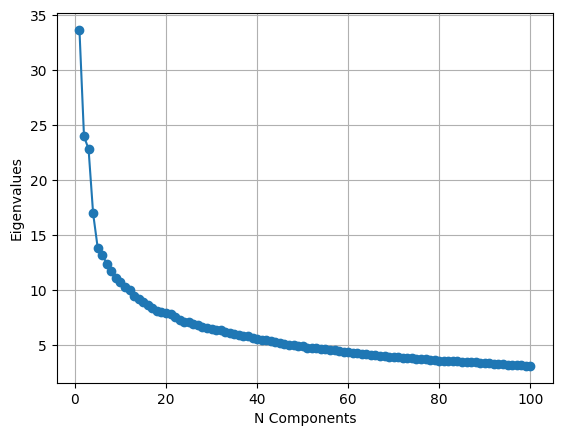

In [10]:
eigenvalues=kpca.eigenvalues_
plt.plot(list(range(1,n_components+1)),eigenvalues, marker='o')
plt.xlabel('N Components')
plt.ylabel('Eigenvalues')
plt.grid()
plt.show()

In [14]:
n_components = 60
kpca = KernelPCA(n_components=n_components, kernel='sigmoid')
nX_train, nX_test, kpca = dim_reductor_naif_explore(kpca, Xt_train, Xt_test, y_train, y_test)

RVE RFs:  0.5467;  MAE:  0.1435
RVE DTs:  0.0083;  MAE:  0.1963
RVE LRs:  0.3398;  MAE:  0.1787
RVE XGBs:  0.5181;  MAE:  0.1458
RVE KNNs:  0.6156;  MAE:  0.1253
RVE SVRs:  0.6195;  MAE:  0.1299
RVE ADAs:  0.3149;  MAE:  0.1864


### PCA Research

In [9]:
n_components = 1000
pca = PCA(n_components= n_components)
nX_train, nX_test, pca = dim_reductor_naif_explore(pca, Xt_train, Xt_test, y_train, y_test)

RVE DTs:  0.1216;  MAE:  0.1892
RVE XGBs:  0.5030;  MAE:  0.1499
RVE KNNs:  0.5655;  MAE:  0.1352
RVE SVRs:  0.6466;  MAE:  0.1222


In [10]:
explained_variance_ratio=pca.explained_variance_ratio_
cumsum_explained_variance = np.cumsum(explained_variance_ratio)
print(cumsum_explained_variance[-1])

0.9224496284744667


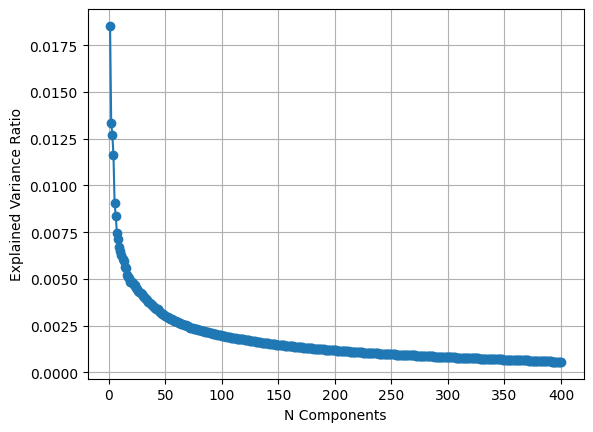

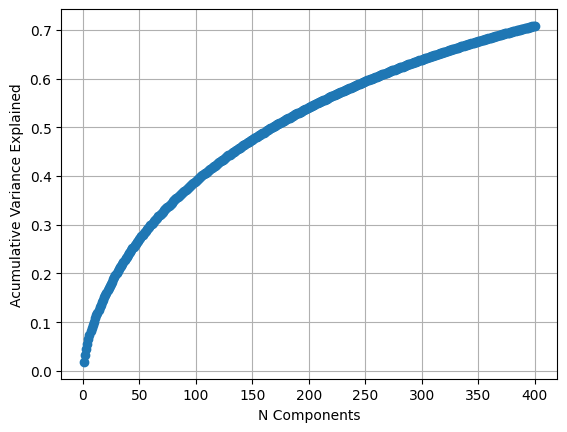

In [12]:
explained_variance_ratio=pca.explained_variance_ratio_
plt.plot(list(range(1,n_components+1)),explained_variance_ratio, marker='o')
plt.xlabel('N Components')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()
cumsum_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(list(range(1,n_components+1)),cumsum_explained_variance, marker='o')
plt.xlabel('N Components')
plt.ylabel('Acumulative Variance Explained')
plt.grid()
plt.show()

In [22]:
n_components = 85
pca = PCA(n_components= n_components)
pca.fit(Xt_train)
nX_train = pca.transform(Xt_train)
nX_test = pca.transform(Xt_test)
naif_model_testingR(nX_train, nX_test,y_train, y_test)
# nX_train, nX_test, pca = dim_reductor_naif_explore(pca, Xt_train, Xt_test, y_train, y_test)

RVE RFs:  0.5452;  MAE:  0.1434
RVE DTs:  0.0750;  MAE:  0.1902
RVE LRs:  0.3941;  MAE:  0.1703
RVE XGBs:  0.5278;  MAE:  0.1450
RVE KNNs:  0.6168;  MAE:  0.1242
RVE SVRs:  0.6208;  MAE:  0.1300
RVE ADAs:  0.3792;  MAE:  0.1759


### Model Tuning

In [3]:
def print_statistics(truth, preds):    
    print("The RVE is: ", explained_variance_score(truth, preds))
    print("The rmse is: ", mean_squared_error(truth, preds, squared=False))
    corr, p = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,p))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))

In [4]:
def explore_model_2d(X, y,model, model_name, hyperparams_grid,metrics={'RVE':explained_variance_score, 'MAE':mean_absolute_error, 'Pearson':pearsonr}, sort_by=['RVE','MAE','Pearson'], ascending=[False,True,False], show_results=True, n_splits=5):
    '''
    metrics = {'RVE':explained_variance_score, 'MAE':mean_absolute_error, 'Pearson':pearsonr}
    hyperparams_grid = {'C':[0.1,1,10,100], 'epsilon':[0.001,0.01,0.1,1,10]}
    model_name = 'StandardScaler/KernelPCA(n_components=100, kernel='sigmoid')/SVR (por ejemplo)
    '''
    # Creamos el diccionario solucion, luego pasara a DataFrame por cuestion de rigurosidad
    # tendra la estructura {'model':[nombre de los modelos segun los parametros]
    #                       'hyp1':[valores del hyp 1]
    #                       'hyp2':[valores del hyp 2]
    #                       'metrica':[valores de la metrica para el modelo]
    # Tener en cuenta que el DataFrame se construirá de forma que cada columna es cada 'key'}
    dict_results = {'model':[]}
    
    hyperparams_names = list(hyperparams_grid.keys())
    hyperparams_values = list(hyperparams_grid.values())
    hyperparams_values_len = tuple(len(val) for val in hyperparams_values)
    # Vamos a usar KFold, podemos modificar el n_splits por eso lo pasamos como parametro, pero por estandar es 5
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    kfold.get_n_splits(X)
    # Para completar el diccionario solucion, añadimos cada key y le asociamos una lista vacia, luego la iremos rellenando
    for h in hyperparams_names: dict_results[h]=[]
    for metric in metrics: dict_results[metric]=[]
    # Generamos un array de zeros para visualizarlo luego
    arr_results = np.zeros(hyperparams_values_len+tuple([len(list(metrics.keys()))]))
    hyp1,hyp2 = hyperparams_names
    
    for i,val1 in tqdm(enumerate(hyperparams_values[0])):
        # recorremos los valores del primer hyperparametro
        for j, val2 in enumerate(hyperparams_values[1]):
            # recorremos los valores del segundo hyperparametro
            
            # Hacemos esto para el KFold, es lo que hizo en su dia el profesor
            TRUTH_nfold=None
            PREDS_nfold=None
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                # Generamos el modelo y le metemos los parametros correspondientes
                model = model.set_params(**{hyp1:val1,hyp2:val2})
                # Entrenamos
                model.fit(X_train,y_train)
                # Predecimos
                preds = model.predict(X_test)
            # Apilamos los resultados de cada 'fold' para luego evaluarlos en conjunto
            if TRUTH_nfold is None:
                PREDS_nfold=preds
                TRUTH_nfold=y_test
            else:
                PREDS_nfold=np.hstack((PREDS_nfold, preds))
                TRUTH_nfold=np.hstack((TRUTH_nfold, y_test))
            
            # Recorremos cada metrica para evaluar los resultados
            for k, (metric_name, metric) in enumerate(metrics.items()):
                if metric_name=='Pearson':
                    # El caso de pearson es particular porque para poder representarlo solo
                    # podemos hacerlo con el primer valor, el segundo es el p-value
                    # por eso lo meto en un if (esto es poco elegante pero funcional)
                    m,_= metric(TRUTH_nfold, PREDS_nfold)
                else:
                    m= metric(TRUTH_nfold, PREDS_nfold)
                # Metemos el resultado de la metrica en el array para la visualizacion
                arr_results[i,j,k] = m
                # Metemos el resultado de la metrica en el diccionario solucion
                dict_results[metric_name].append(m)
                
            # Añadimos el resto de valores al diccionario solucion
            dict_results['model'].append(f'{model_name}({hyp1}={val1},{hyp2}={val2})')
            dict_results[hyp1].append(val1)
            dict_results[hyp2].append(val2)
    if show_results:
        # Llamamos a la funcion de visualizacion
        visualize_results_2d(arr_results, hyperparams_grid, metrics)
    # Lo convertimos en DataFrame
    dataframe_results = pd.DataFrame.from_dict(dict_results)
    # El if de abajo es por si quieres ordenarlo, por defecto está que si, pero si cambias las metricas ten cuidado que tienes
    # que indicar el sort_by y el ascending de forma correspondiente
    return dataframe_results.copy().sort_values(by=sort_by, ascending=ascending) if sort_by else dataframe_results.copy()

def visualize_results_2d(results_values, hyperparams_grid, metrics): 
    ylabels = list(metrics.keys())
    hyp_name1, hyp_name2 = list(hyperparams_grid.keys())
    hyp_val1, hyp_val2 = list(hyperparams_grid.values())
    # Generamos en una fila tantos espacios como graficas vayamos a crear (una por cada metrica)
    fig, axs = plt.subplots(nrows=1, ncols=len(ylabels), figsize=(12,4))
    for k in range(len(ylabels)):
        for i, m1 in enumerate(hyp_val1):
            axs[k].plot(hyp_val2, results_values[i, :, k], marker='o', label=f"{hyp_name1} = {m1}")
            label_points(hyp_val2, results_values[i, :, k], hyp_val2,axs[k])         
        axs[k].set_xlabel(hyp_name2)
        axs[k].set_ylabel(ylabels[k])
        axs[k].grid()
        axs[k].set_title(f'Impact on {ylabels[k]}')
        axs[k].set_xscale('log')
        axs[k].legend()
    plt.show()
    
def label_points(x, y, labels, ax, offset=0):
    for i, label in enumerate(labels):
        ax.text(x[i], y[i]+offset, f'{label:.2f}', fontsize=8, ha='left', va='bottom')

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X_main,y_main,test_size=0.3, random_state=42)

### Fix Scaler

In [56]:
scaler = StandardScaler()
scaler_name = 'StandardScaler'
scaler.fit(X_train)
Xt_train = scaler.transform(X_train)
Xt_test = scaler.transform(X_test)

### Fix Dim Reductor
Execute only one line of code

In [48]:
dim_reductor_name='PCA'
n_components = 500
pca = PCA(n_components= n_components)
pca.fit(Xt_train)
nX_train = pca.transform(Xt_train)
nX_test = pca.transform(Xt_test)

In [32]:
dim_reductor_name='KernelPCA'
kpca = KernelPCA(n_components=150, kernel='sigmoid')
kpca.fit(Xt_train)
nX_train = kpca.transform(Xt_train)
nX_test = kpca.transform(Xt_test)

In [57]:
dim_reductor_name='SelectFromModel_RF'
rf = RandomForestRegressor()
sel = SelectFromModel(estimator=rf, threshold="mean")
sel.fit(Xt_train,y_train)
nX_train = sel.transform(Xt_train)
nX_test = sel.transform(Xt_test)

#### Model Tuning

#### SupportVectorRegressor

0it [00:00, ?it/s]

3it [03:26, 68.78s/it] 


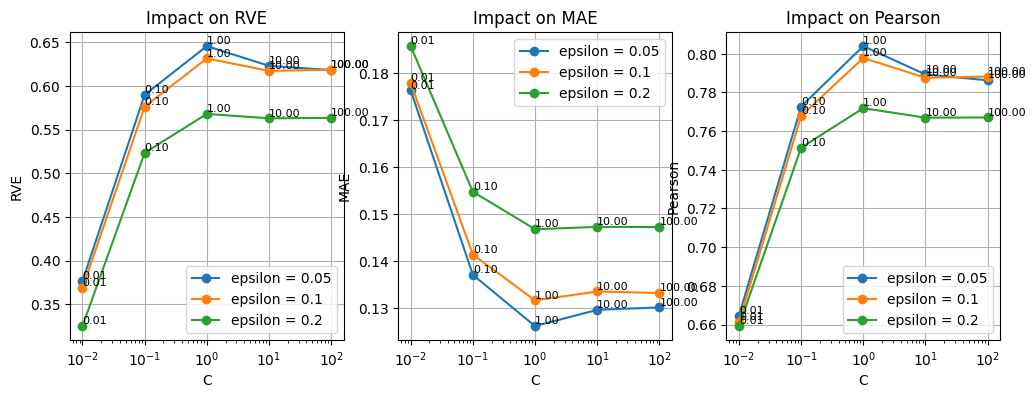

In [54]:
df_result_svr = explore_model_2d(X=nX_train, y=y_train,model=SVR(), model_name=f'{scaler_name}/{dim_reductor_name}/SVR',
                 hyperparams_grid={'epsilon':[0.05,0.1,0.2],'C':[0.01, 0.1, 1.0, 10.0, 100.0]})

In [55]:
df_result_svr.head()

,model,epsilon,C,RVE,MAE,Pearson
2,StandardScaler/SelectFromModel_RF/SVR(epsilon=...,0.05,1.0,0.645657,0.126233,0.803983
7,StandardScaler/SelectFromModel_RF/SVR(epsilon=...,0.10,1.0,0.631580,0.131711,0.797848
3,StandardScaler/SelectFromModel_RF/SVR(epsilon=...,0.05,10.0,0.623070,0.129702,0.789352
9,StandardScaler/SelectFromModel_RF/SVR(epsilon=...,0.10,100.0,0.618503,0.133266,0.788233
4,StandardScaler/SelectFromModel_RF/SVR(epsilon=...,0.05,100.0,0.618224,0.130204,0.786315


In [58]:
best_svr = SVR(epsilon=0.05, C=1.0)
best_svr.fit(nX_train, y_train)

preds=best_svr.predict(nX_test)
print_statistics(y_test, preds)

The RVE is:  0.644154264208493
The rmse is:  0.1655202059733584
The Correlation Score is is: 0.8026 (p-value=0.000000e+00)

The Maximum Error is is:  0.7966951073919644
The Mean Absolute Error is:  0.12159561453466268


#### KNeighborsRegressor

2it [00:06,  3.26s/it]


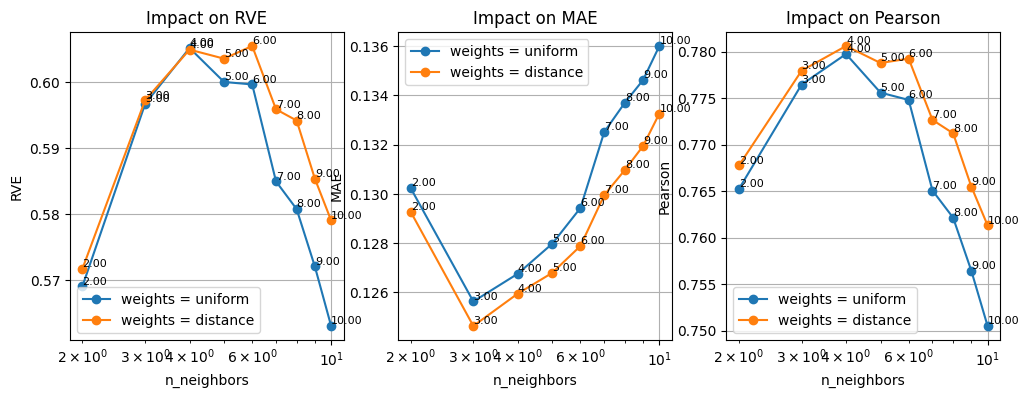

In [58]:
df_result_knn = explore_model_2d(X=nX_train, y=y_train,model=KNeighborsRegressor(), model_name=f'{scaler_name}/{dim_reductor_name}/KNN',
                 hyperparams_grid={'weights':['uniform','distance'],'n_neighbors':[2,3,4,5,6,7,8,9,10]})

In [59]:
df_result_knn.head()

,model,weights,n_neighbors,RVE,MAE,Pearson
13,StandardScaler/SelectFromModel_RF/KNN(weights=...,distance,6,0.605390,0.127875,0.779240
2,StandardScaler/SelectFromModel_RF/KNN(weights=...,uniform,4,0.605085,0.126746,0.779732
11,StandardScaler/SelectFromModel_RF/KNN(weights=...,distance,4,0.604840,0.125939,0.780600
12,StandardScaler/SelectFromModel_RF/KNN(weights=...,distance,5,0.603473,0.126782,0.778771
3,StandardScaler/SelectFromModel_RF/KNN(weights=...,uniform,5,0.599952,0.127967,0.775586


In [59]:
best_knn=KNeighborsRegressor(n_neighbors=6,weights='distance')
best_knn.fit(nX_train, y_train)

preds=best_knn.predict(nX_test)
print_statistics(y_test, preds)

The RVE is:  0.5971860721997111
The rmse is:  0.17601389799732234
The Correlation Score is is: 0.7761 (p-value=0.000000e+00)

The Maximum Error is is:  0.9768065402557025
The Mean Absolute Error is:  0.12672897222083745


#### XGBRegressor

4it [01:29, 22.28s/it]


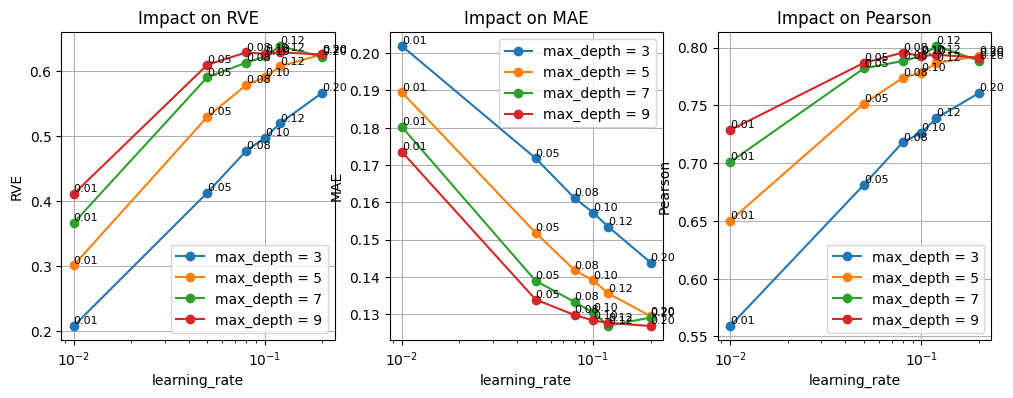

In [60]:
df_result_xgb = explore_model_2d(X=nX_train, y=y_train,model=XGBRegressor(), model_name=f'{scaler_name}/{dim_reductor_name}/XGB',
                 hyperparams_grid={'max_depth': [3, 5, 7, 9],'learning_rate': [0.01, 0.05, 0.08, 0.1, 0.12, 0.2]})

In [61]:
df_result_xgb.head()

,model,max_depth,learning_rate,RVE,MAE,Pearson
16,StandardScaler/SelectFromModel_RF/XGB(max_dept...,7,0.12,0.639210,0.126936,0.801380
20,StandardScaler/SelectFromModel_RF/XGB(max_dept...,9,0.08,0.629389,0.129782,0.795686
22,StandardScaler/SelectFromModel_RF/XGB(max_dept...,9,0.12,0.629305,0.127652,0.793792
21,StandardScaler/SelectFromModel_RF/XGB(max_dept...,9,0.10,0.626975,0.128337,0.792643
11,StandardScaler/SelectFromModel_RF/XGB(max_dept...,5,0.20,0.626374,0.129455,0.792675


In [62]:
best_xgb=XGBRegressor(max_depth=9, learning_rate=0.12)
best_xgb.fit(nX_train,y_train)
preds=best_xgb.predict(nX_test)
print_statistics(y_test,preds)

The RVE is:  0.6343203476362258
The rmse is:  0.16778085334945536
The Correlation Score is is: 0.7965 (p-value=0.000000e+00)

The Maximum Error is is:  0.8994579315185547
The Mean Absolute Error is:  0.12447184007114152


In [30]:
best_xgb=XGBRegressor(max_depth=11, learning_rate=0.12)
best_xgb.fit(Xt_train,y_train)
preds=best_xgb.predict(Xt_test)
print_statistics(y_test,preds)

The RVE is:  0.6416950609729878
The rmse is:  0.16611034214016634
The Correlation Score is is: 0.8012 (p-value=0.000000e+00)

The Maximum Error is is:  0.8206473400388489
The Mean Absolute Error is:  0.12317868722851384


#### RandomForestRegressor

In [62]:
hyperparams_grid={'max_depth': [3, 5, 7, None], 'n_estimators': [50,100,150]}
grid_search = GridSearchCV(RandomForestRegressor(), hyperparams_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(nX_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, None],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [63]:
res = pd.DataFrame(grid_search.cv_results_)
res = res.sort_values(by=["rank_test_score"])
res[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
11,"{'max_depth': None, 'n_estimators': 150}",1,-0.030244,0.001864
9,"{'max_depth': None, 'n_estimators': 50}",2,-0.030351,0.001931
10,"{'max_depth': None, 'n_estimators': 100}",3,-0.030389,0.001725
8,"{'max_depth': 7, 'n_estimators': 150}",4,-0.043883,0.001692
7,"{'max_depth': 7, 'n_estimators': 100}",5,-0.043890,0.001744
6,"{'max_depth': 7, 'n_estimators': 50}",6,-0.044016,0.001823
5,"{'max_depth': 5, 'n_estimators': 150}",7,-0.049841,0.001962
4,"{'max_depth': 5, 'n_estimators': 100}",8,-0.049920,0.002037
3,"{'max_depth': 5, 'n_estimators': 50}",9,-0.050017,0.002114
2,"{'max_depth': 3, 'n_estimators': 150}",10,-0.058120,0.001877


In [64]:
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'max_depth': None, 'n_estimators': 150}


In [70]:
best_rf=RandomForestRegressor(n_estimators=150,max_depth=None)
best_rf.fit(nX_train,y_train)
preds=best_rf.predict(nX_test)
print_statistics(y_test,preds)

The RVE is:  0.6252021685669147
The rmse is:  0.16983923806961446
The Correlation Score is is: 0.7935 (p-value=0.000000e+00)

The Maximum Error is is:  0.9019624000177775
The Mean Absolute Error is:  0.12705739011644815


#### MLPRegressor

In [ ]:
hyperparams_grid={'hidden_layer_sizes': [(100,),(250,),(500,),(100,100,),(250,100,)],'alpha': [0.0001,0.001,0.01,0.1]}
grid_search = GridSearchCV(MLPRegressor(), hyperparams_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(nX_train, y_train)

In [ ]:
res = pd.DataFrame(grid_search.cv_results_)
res = res.sort_values(by=["rank_test_score"])
res[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
19,"{'alpha': 0.1, 'hidden_layer_sizes': (250, 100)}",1,-0.031272,0.002521
18,"{'alpha': 0.1, 'hidden_layer_sizes': (100, 100)}",2,-0.031509,0.003055
17,"{'alpha': 0.1, 'hidden_layer_sizes': (500,)}",3,-0.031584,0.001543
16,"{'alpha': 0.1, 'hidden_layer_sizes': (250,)}",4,-0.031907,0.002774
15,"{'alpha': 0.1, 'hidden_layer_sizes': (100,)}",5,-0.039599,0.006668
14,"{'alpha': 0.01, 'hidden_layer_sizes': (250, 100)}",6,-0.042826,0.011205
13,"{'alpha': 0.01, 'hidden_layer_sizes': (100, 100)}",7,-0.056361,0.005447
3,"{'alpha': 0.0001, 'hidden_layer_sizes': (100, ...",8,-0.058469,0.004816
8,"{'alpha': 0.001, 'hidden_layer_sizes': (100, 1...",9,-0.058911,0.005424
9,"{'alpha': 0.001, 'hidden_layer_sizes': (250, 1...",10,-0.062677,0.009064


In [ ]:
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'alpha': 0.1, 'hidden_layer_sizes': (250, 100)}


In [63]:
best_mlp=MLPRegressor(hidden_layer_sizes=(250,100),alpha=0.1)
best_mlp.fit(nX_train,y_train)
preds=best_mlp.predict(nX_test)
print_statistics(y_test,preds)

The RVE is:  0.5933884428423511
The rmse is:  0.17707236387210648
The Correlation Score is is: 0.7787 (p-value=0.000000e+00)

The Maximum Error is is:  0.7830773753961557
The Mean Absolute Error is:  0.12983705305903542


#### StackingRegressor

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X_main,y_main,test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
Xt_train = scaler.transform(X_train)
Xt_test = scaler.transform(X_test)

rf = RandomForestRegressor()
sel = SelectFromModel(estimator=rf, threshold="mean")
sel.fit(Xt_train,y_train)
nX_train = sel.transform(Xt_train)
nX_test = sel.transform(Xt_test)

In [76]:
base_models = [
    ('svr', SVR(C=1, epsilon=0.05)),
    ('xgb', XGBRegressor(max_depth=9,learning_rate=0.12)),
    ('knn', KNeighborsRegressor(n_neighbors=4, weights='distance')),
    # ('rf', RandomForestRegressor(n_estimators=150, max_depth=None)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(500,),alpha=0.1))
]
meta_model = LinearRegression()
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

In [77]:
stacking_model

StackingRegressor(estimators=[('svr', SVR(C=1, epsilon=0.05)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interactio...
                                            max_delta_step=None, max_depth=9,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('knn',
                               KNeighborsRegressor(n_neighbors=4,
                                                   weights='distance')),
                              ('mlp',
                               MLPRegressor(alpha=0.1,
                                            hidden_layer_sizes=(500,)))],
                  final_estimator=LinearRegression())

In [78]:
stacking_model.fit(nX_train,y_train)
preds=stacking_model.predict(nX_test)
print_statistics(y_test,preds)

The RVE is:  0.6603952154880159
The rmse is:  0.16163387869663948
The Correlation Score is is: 0.8127 (p-value=0.000000e+00)

The Maximum Error is is:  0.8242624014535398
The Mean Absolute Error is:  0.11758295927313392


### Other tests outside the content

In [9]:
scaler = StandardScaler()
scaler_name = 'StandardScaler'
scaler.fit(X_train)
Xt_train = scaler.transform(X_train)
Xt_test = scaler.transform(X_test)

#### InterpretML: ExplainableBoostingRegressor

In [10]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show

ebr = ExplainableBoostingRegressor(feature_names=col_names)
ebr.fit(Xt_train, y_train)

ExplainableBoostingRegressor(feature_names=['D00', 'D01', 'D02', 'D03', 'D04',
                                            'D05', 'D06', 'D07', 'D08', 'D09',
                                            'D10', 'D11', 'D12', 'D13', 'D14',
                                            'D15', 'D16', 'D17', 'D18', 'D19',
                                            'D20', 'D21', 'D22', 'D23', 'D24',
                                            'D25', 'D26', 'D27', 'D28', 'D29', ...])

In [24]:
preds = ebr.predict(Xt_test)
print_statistics(y_test, preds)

The RVE is:  0.5824718184953473
The rmse is:  0.17922728619529563
The Correlation Score is is: 0.7632 (p-value=0.000000e+00)

The Maximum Error is is:  0.7429176139820703
The Mean Absolute Error is:  0.13836623679047289


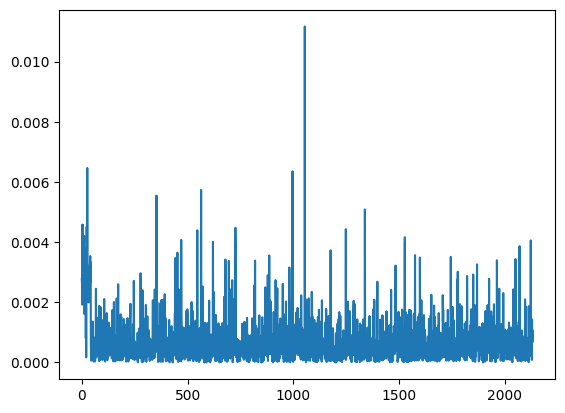

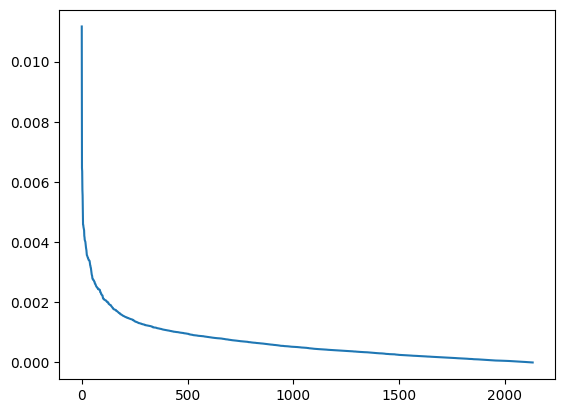

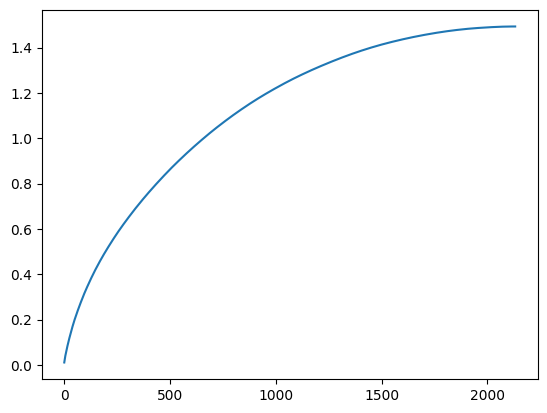

In [11]:
term_importances = ebr.term_importances()
term_real_importances = term_importances[:X_train.shape[1]]
plt.plot(np.arange(len(col_names)),term_real_importances)
plt.show()

sorted_importances = np.sort(term_real_importances)[::-1]
plt.plot(np.arange(len(col_names)),sorted_importances)
plt.show()

cumsum_importances = np.cumsum(sorted_importances)
plt.plot(np.arange(len(col_names)),cumsum_importances)
plt.show()

In [29]:
def array_equality(array1, array2):
    set1 = set(array1)
    set2 = set(array2)
    intersection = set1.intersection(set2)
    return len(intersection)/len(array1)

In [27]:
N,M=Xt_train.shape
features_sel=sel.get_support()
features_selected_sel =np.arange(M)[features_sel]

In [13]:
features_selected_ebr=ebr.term_importances().argsort()[::-1]

In [63]:
features_selected_ebr_comparative = features_selected_ebr[:len(features_selected_sel)]
array_eq = array_equality(features_selected_ebr_comparative, features_selected_sel)
print(f'Both selectors has {array_eq*100}% of the same features selected')

Both selectors has 57.70308123249299% of the same features selected


### FeatureSelection from EBR

In [14]:
# Get out artificial features
features_selected_ebr = features_selected_ebr[features_selected_ebr<=Xt_train.shape[1]-1]

In [15]:
features_selected_ebr_small = features_selected_ebr[:500]

In [16]:
nX_train = Xt_train[:,features_selected_ebr_small]
nX_test = Xt_test[:,features_selected_ebr_small]
dim_reductor_name='FeatureSelector_EBR'
scaler_name='StandardScaler'

In [81]:
best_svr = SVR(epsilon=0.01, C=1.0)
best_svr.fit(nX_train, y_train)

preds=best_svr.predict(nX_test)
print_statistics(y_test, preds)

The RVE is:  0.6435600913691967
The rmse is:  0.16573403626766617
The Correlation Score is is: 0.8028 (p-value=0.000000e+00)

The Maximum Error is is:  0.8163420017984815
The Mean Absolute Error is:  0.12134141972816288


In [82]:
best_knn=KNeighborsRegressor(n_neighbors=6,weights='distance')
best_knn.fit(nX_train, y_train)

preds=best_knn.predict(nX_test)
print_statistics(y_test, preds)

The RVE is:  0.6065765343795027
The rmse is:  0.17392523370201682
The Correlation Score is is: 0.7821 (p-value=0.000000e+00)

The Maximum Error is is:  0.9527468429567603
The Mean Absolute Error is:  0.124668326783707


In [83]:
best_rf=RandomForestRegressor(n_estimators=150)
best_rf.fit(nX_train,y_train)
preds=best_rf.predict(nX_test)
print_statistics(y_test,preds)

The RVE is:  0.6205265577291266
The rmse is:  0.17095437082916687
The Correlation Score is is: 0.7905 (p-value=0.000000e+00)

The Maximum Error is is:  0.8839975976449999
The Mean Absolute Error is:  0.1280534591645088


In [85]:
best_mlp=MLPRegressor(hidden_layer_sizes=(100,100),alpha=0.1, max_iter=500)
best_mlp.fit(nX_train,y_train)
preds=best_mlp.predict(nX_test)
print_statistics(y_test,preds)

The RVE is:  0.5975288657108259
The rmse is:  0.17593076832498974
The Correlation Score is is: 0.7831 (p-value=0.000000e+00)

The Maximum Error is is:  0.8923342700100755
The Mean Absolute Error is:  0.12953220300390975


In [100]:
best_xgb=XGBRegressor(max_depth=12, learning_rate=0.15)
best_xgb.fit(nX_train,y_train)
preds=best_xgb.predict(nX_test)
print_statistics(y_test,preds)

The RVE is:  0.6324832509007438
The rmse is:  0.1683119909660024
The Correlation Score is is: 0.7953 (p-value=0.000000e+00)

The Maximum Error is is:  0.9073188900947571
The Mean Absolute Error is:  0.12379177431066092


In [19]:
base_models = [
    ('svr', SVR(C=1, epsilon=0.01)),
    ('xgb', XGBRegressor(max_depth=12,learning_rate=0.15)),
    ('knn', KNeighborsRegressor(n_neighbors=6, weights='distance')),
    # ('rf', RandomForestRegressor(n_estimators=150)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100,100),alpha=0.1, max_iter=500))
]
meta_model = LinearRegression()
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(nX_train,y_train)
preds=stacking_model.predict(nX_test)
print_statistics(y_test,preds)

The RVE is:  0.6675267953212163
The rmse is:  0.15994881677223546
The Correlation Score is is: 0.8172 (p-value=0.000000e+00)

The Maximum Error is is:  0.8245542620289393
The Mean Absolute Error is:  0.11598897261677577


## Final Model

In [27]:
# scaler
scaler = StandardScaler()
# dim reductor
rf = RandomForestRegressor()
sel = SelectFromModel(estimator=rf, threshold="mean")
# model
base_models = [
    ('svr', SVR(C=1, epsilon=0.05)),
    ('xgb', XGBRegressor(max_depth=9,learning_rate=0.12)),
    ('knn', KNeighborsRegressor(n_neighbors=4, weights='distance')),
    # ('rf', RandomForestRegressor(n_estimators=150, max_depth=None)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(500,),alpha=0.1))
]
meta_model = LinearRegression()
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# final pipeline
pipeline = Pipeline(steps=[('scaler', scaler),('dim_reductor',sel),('model',stacking_model)])
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_reductor',
                 SelectFromModel(estimator=RandomForestRegressor(),
                                 threshold='mean')),
                ('model',
                 StackingRegressor(estimators=[('svr', SVR(C=1, epsilon=0.05)),
                                               ('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device=None,
                                                             early_sto...
                                                             max_delta_step=None,
                                                             max_depth=9,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...)),
                                               ('knn',
                                                KNeighborsRegressor(n_neighbors=4,
                                                                    weights='distance')),
                                               ('mlp',
                                                MLPRegressor(alpha=0.1,
                                                             hidden_layer_sizes=(500,)))],
                                   final_estimator=LinearRegression()))])

In [28]:
pipeline.fit(X_main, y_main)
preds=pipeline.predict(X_ivs)

In [39]:
preds_reshape = np.reshape(preds, (-1, 1))

np.savetxt('02.txt', preds_reshape, fmt="%10.10f")